# Training a Foreground Segmentation Tool with DINOv3

In this tutorial, we will train a linear foreground segmentation model using DINOv3 features.

### Setup

Let's start by loading some pre-requisites and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

In [14]:
import io
import os
import pickle
import tarfile
import urllib

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.transforms.functional as TF
from tqdm import tqdm

DINOV3_GITHUB_LOCATION = "/home/lades/computer_vision/wesley/dino-soja/dinov3"

if os.getenv("DINOV3_LOCATION") is not None:
    DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
else:
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

print(f"DINOv3 location set to {DINOV3_LOCATION}")

DINOv3 location set to /home/lades/computer_vision/wesley/dino-soja/dinov3


### Model

Let's load the DINOv3 model. For this notebook, we will be using the ViT-L model, but if you have more or less hardware constraints, you can easily load any other DINOv3 model!

In [15]:
import torch

REPO_DIR = f"{DINOV3_LOCATION}"

# DINOv3 ViT models pretrained on web images
dinov3_vits16 = torch.hub.load(REPO_DIR, 'dinov3_vits16', source='local', weights='https://dinov3.llamameta.net/dinov3_vits16/dinov3_vits16_pretrain_lvd1689m-08c60483.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vits16plus = torch.hub.load(REPO_DIR, 'dinov3_vits16plus', source='local', weights='https://dinov3.llamameta.net/dinov3_vits16plus/dinov3_vits16plus_pretrain_lvd1689m-4057cbaa.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vitb16 = torch.hub.load(REPO_DIR, 'dinov3_vitb16', source='local', weights='https://dinov3.llamameta.net/dinov3_vitb16/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vitl16 = torch.hub.load(REPO_DIR, 'dinov3_vitl16', source='local', weights='https://dinov3.llamameta.net/dinov3_vitl16/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vith16plus = torch.hub.load(REPO_DIR, 'dinov3_vith16plus', source='local', weights='https://dinov3.llamameta.net/dinov3_vith16plus/dinov3_vith16plus_pretrain_lvd1689m-7c1da9a5.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vit7b16 = torch.hub.load(REPO_DIR, 'dinov3_vit7b16', source='local', weights='https://dinov3.llamameta.net/dinov3_vit7b16/dinov3_vit7b16_pretrain_lvd1689m-a955f4ea.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')

# DINOv3 ConvNeXt models pretrained on web images
#dinov3_convnext_tiny = torch.hub.load(REPO_DIR, 'dinov3_convnext_tiny', source='local', weights='https://dinov3.llamameta.net/dinov3_convnext_tiny/dinov3_convnext_tiny_pretrain_lvd1689m-21b726bb.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_convnext_small = torch.hub.load(REPO_DIR, 'dinov3_convnext_small', source='local', weights='https://dinov3.llamameta.net/dinov3_convnext_small/dinov3_convnext_small_pretrain_lvd1689m-296db49d.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_convnext_base = torch.hub.load(REPO_DIR, 'dinov3_convnext_base', source='local', weights='https://dinov3.llamameta.net/dinov3_convnext_base/dinov3_convnext_base_pretrain_lvd1689m-801f2ba9.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_convnext_large = torch.hub.load(REPO_DIR, 'dinov3_convnext_large', source='local', weights='https://dinov3.llamameta.net/dinov3_convnext_large/dinov3_convnext_large_pretrain_lvd1689m-61fa432d.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')

# DINOv3 ViT models pretrained on satellite imagery
dinov3_vitl16 = torch.hub.load(REPO_DIR, 'dinov3_vitl16', source='local', weights='https://dinov3.llamameta.net/dinov3_vitl16/dinov3_vitl16_pretrain_sat493m-eadcf0ff.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')
#dinov3_vit7b16 = torch.hub.load(REPO_DIR, 'dinov3_vit7b16', source='local', weights='https://dinov3.llamameta.net/dinov3_vit7b16/dinov3_vit7b16_pretrain_sat493m-a6675841.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725')

In [16]:
# examples of available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

MODEL_NAME = MODEL_DINOV3_VITL

model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local",
    weights="https://dinov3.llamameta.net/dinov3_vitl16/dinov3_vitl16_pretrain_sat493m-eadcf0ff.pth?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiamVkbGhoemY3bnlpYmJ1NnVhdmJ2NGtrIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGlub3YzLmxsYW1hbWV0YS5uZXRcLyoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE3NTcxNzAwMzh9fX1dfQ__&Signature=YktyLH8aRk9MBqJe9X6LfVwzezdJo51sVHwKx29n7BTo88T8QR4HHDj9kCyi2wVyUsI4qDVXoJWfHDdbbkxiEPqXukQUDVtWq25HG5ODC8JP-%7ENDbRUPQYkPUHER6ssK9WK5K4Nva6EdiBtIKqMm9G3RMh1uFA86wGz4X4FvgDiaRh4aCWsM5jLg3Gsvr1QIFoPpgAO%7EOnYYG-wxj1VRnrY32Wm6OoNw61M96kgfPXNxEFwYphBu2ImJykrvgc0Yea1J2jV3FwECfDmdVftQ3okThpbxwPJ-wsAxDXc2z2-bJaPQowafr8afLKO2hFl57iMiDQELW2DDS9GYgvpw7Q__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=783982447506725"
)
model.cuda()

# Usar normalização para imagens de satélite
SATELLITE_MEAN = (0.430, 0.411, 0.296)
SATELLITE_STD = (0.213, 0.156, 0.143)

### Data
Now that we have the model set up, let's load the training data. It consists of:

- images in `jpg` format:
```
https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_images.tar.gz
```

- and segmentation masks stored as alpha channels in `png` files:
```
https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_labels.tar.gz
```

In total, there are 9 training image / mask pairs.


In [ ]:
from pathlib import Path

def load_local_dataset(dataset_root: str):
    """Carrega imagens RGB e labels do dataset local"""
    dataset_path = Path(dataset_root)
    
    images = []
    labels = []
    
    # Carregar dados de treino
    for split in ['train']:
        rgb_path = dataset_path / "rgb" / split
        label_path = dataset_path / "labels" / split
        
        # Verificar se os diretórios existem
        if not rgb_path.exists():
            print(f"Aviso: Diretório {rgb_path} não encontrado")
            continue
        if not label_path.exists():
            print(f"Aviso: Diretório {label_path} não encontrado")
            continue
        
        # Obter lista de arquivos RGB
        rgb_files = sorted(list(rgb_path.glob("*.png")) + list(rgb_path.glob("*.jpg")))
        
        print(f"Encontrados {len(rgb_files)} arquivos RGB em {split}")
        
        for rgb_file in rgb_files:
            # Encontrar label correspondente substituindo a extensão de .jpg por .png
            label_file = label_path / rgb_file.name
            label_file = label_file.with_suffix('.png' if rgb_file.suffix.lower() == '.jpg' else rgb_file.suffix)

            if label_file.exists():
                try:
                    # Carregar imagem RGB
                    rgb_image = Image.open(rgb_file).convert('RGB')
                    images.append(rgb_image)
                    
                    # Carregar label RGB (manter as cores originais)
                    label_image = Image.open(label_file).convert('RGB')
                    labels.append(label_image)
                    
                except Exception as e:
                    print(f"Erro ao carregar {rgb_file}: {e}")
            else:
                print(f"Label não encontrada para {rgb_file.name}")
    
    return images, labels

Encontrados 764 arquivos RGB em train
764 imagens e labels foram carregadas do dataset daninhas_multiclasse2


In [12]:
from pathlib import Path
import shutil
import os
import numpy as np
import random
import tqdm

def create_train_val(dataset_root: str, percent_val: float = 0.2):
    dataset_path = Path(dataset_root)
    train_rgb_path = dataset_path / "rgb" / "train"
    val_rgb_path = dataset_path / "rgb" / "val"


    os.rmdir(dataset_path / 'rgb') if (dataset_path / 'rgb').exists() else None
    
    os.makedirs(val_rgb_path, exist_ok=True)
    os.makedirs(train_rgb_path, exist_ok=True)
    
    # Obter lista de arquivos RGB
    rgb_files = sorted(list(dataset_path.glob("*.png")) + list(dataset_path.glob("*.jpg")))
    print(f"Encontrados {len(rgb_files)} arquivos RGB em train")
    np.random.shuffle(rgb_files)

    split_index = int((1 - percent_val) * len(rgb_files))
    train_files = rgb_files[:split_index]
    val_files = rgb_files[split_index:]

    print(f"Dividindo em {len(train_files)} arquivos de treino e {len(val_files)} arquivos de validação")

    # Copiar arquivos para os diretórios correspondentes
    for file in tqdm.tqdm(train_files, desc="Copiando arquivos de treino"):
        shutil.copy(file, train_rgb_path / file.name)
    for file in tqdm.tqdm(val_files, desc="Copiando arquivos de validação"):
        shutil.copy(file, val_rgb_path / file.name)

    print(f"Divisão concluída. Foram sorteados {len(train_files)} arquivos de treino e {len(val_files)} arquivos de validação.")

In [21]:
create_train_val("/home/lades/computer_vision/wesley/dataset/soja/224/", percent_val=0.2)

Encontrados 96115 arquivos RGB em train
Dividindo em 76892 arquivos de treino e 19223 arquivos de validação


Copiando arquivos de validação: 100%|██████████| 19223/19223 [00:20<00:00, 954.11it/s] 

Divisão concluída. Foram sorteados 76892 arquivos de treino e 19223 arquivos de validação.


Função para carregar as imagens RGB do dataset sem as labels

Segunda etapa do experimento: será considerado toda imagem como groundtruth

In [64]:
from pathlib import Path
from PIL import Image

def load_local_dataset_without_labels(dataset_root: str):
    """Carrega imagens RGB e labels do dataset local"""
    dataset_path = Path(dataset_root)
    
    images = []
    labels = []
    
    # Carregar dados de treino
    for split in ['train']:
        rgb_path = dataset_path / "rgb" / split
        
        # Verificar se os diretórios existem
        if not rgb_path.exists():
            print(f"Aviso: Diretório {rgb_path} não encontrado")
            continue
        
        # Obter lista de arquivos RGB
        rgb_files = sorted(list(rgb_path.glob("*.png")) + list(rgb_path.glob("*.jpg")))
        
        print(f"Encontrados {len(rgb_files)} arquivos RGB em {split}")
        
        i = 1
        for rgb_file in rgb_files:
        
            if rgb_file.exists():
                try:
                    # Carregar imagem RGB
                    rgb_image = Image.open(rgb_file).convert('RGB')
                    images.append(rgb_image)
                    
                    # Criar label fictícia (todos pixels como foreground)
                    label_image = Image.new('RGB', rgb_image.size, (0, 255, 0))  # Fundo verde (foreground)
                    labels.append(label_image)
                    
                except Exception as e:
                    print(f"Erro ao carregar {rgb_file}: {e}")
            else:
                print(f"Não foi possivel criar label para {rgb_file.name}")
    
    return images, labels

In [65]:
DATASET_ROOT = "/home/lades/computer_vision/wesley/dataset/daninhas_multiclasse2/"
images, labels = load_local_dataset_without_labels(DATASET_ROOT)
n_images = len(images)
print(f"{n_images} imagens foram carregadas do dataset {DATASET_ROOT.split('/')[-1]}")

Encontrados 764 arquivos RGB em train


764 imagens foram carregadas do dataset 


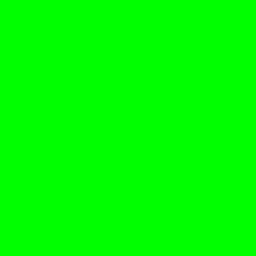

In [28]:
labels[25]

In [29]:
import os

def process_label_for_soja(label_image: Image.Image) -> Image.Image:
    """
    Processa labels RGB do dataset de soja/daninhas
    - Fundo preto (0,0,0) = background
    - Branco (255,255,255) = background 
    - Vermelho, azul, amarelo, verde = foreground (daninhas)
    """
    # Converter para array numpy
    label_array = np.array(label_image)
    
    # Verificar se é uma imagem RGB
    if len(label_array.shape) == 3 and label_array.shape[2] == 3:
        # Detectar pixels de foreground (qualquer pixel que não seja preto ou branco)
        foreground_mask = np.any(label_array != [0, 0, 0], axis=2) & np.any(label_array != [255, 255, 255], axis=2)
        
        # Background = preto OU branco
        background_mask = ~foreground_mask
        
        # Criar máscara binária: 255 = background, 0 = foreground
        binary_mask = np.zeros(label_array.shape[:2], dtype=np.uint8)
        binary_mask[background_mask] = 255
        binary_mask[foreground_mask] = 0
    else:
        # Fallback para imagens grayscale
        binary_mask = (label_array > 0).astype(np.uint8) * 255
    
    return Image.fromarray(binary_mask)


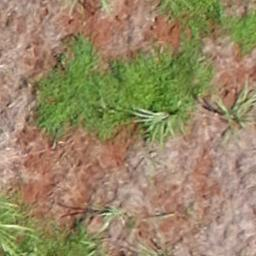

In [21]:
images[25]

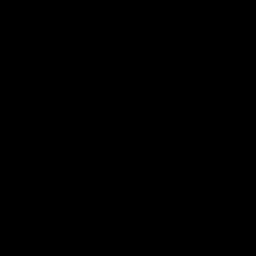

In [30]:
img = process_label_for_soja(images[25])
img

In [31]:

def visualize_label_processing(label_image: Image.Image, index: int = 0):
    """Visualiza o processamento da label"""
    print(f"Showing image / mask at index {index}:")

    image = images[index]
    mask_original = labels[index]

    # Processar a máscara para binária (escala de cinza)
    mask_processed = process_label_for_soja(mask_original)

    # Criar composições usando a máscara processada
    foreground = Image.composite(image, Image.new('RGB', image.size, (0, 0, 0)), mask_processed)

    # Para background, inverter a máscara
    from PIL import ImageOps
    mask_inverted = ImageOps.invert(mask_processed)
    background = Image.composite(Image.new('RGB', image.size, (255, 255, 255)), image, mask_inverted)

    data_to_show = [image, mask_original, mask_processed, foreground, background]
    data_labels = ["Original Image", "Color Label", "Binary Mask", "Foreground", "Background"]

    plt.figure(figsize=(20, 4), dpi=300)
    for i in range(len(data_to_show)):
        plt.subplot(1, len(data_to_show), i + 1)
        if i == 2:  # Máscara binária
            plt.imshow(data_to_show[i], cmap='gray')
        else:
            plt.imshow(data_to_show[i])
        plt.axis('off')
        plt.title(data_labels[i], fontsize=12)
    plt.tight_layout()
    plt.show()

Showing image / mask at index 25:


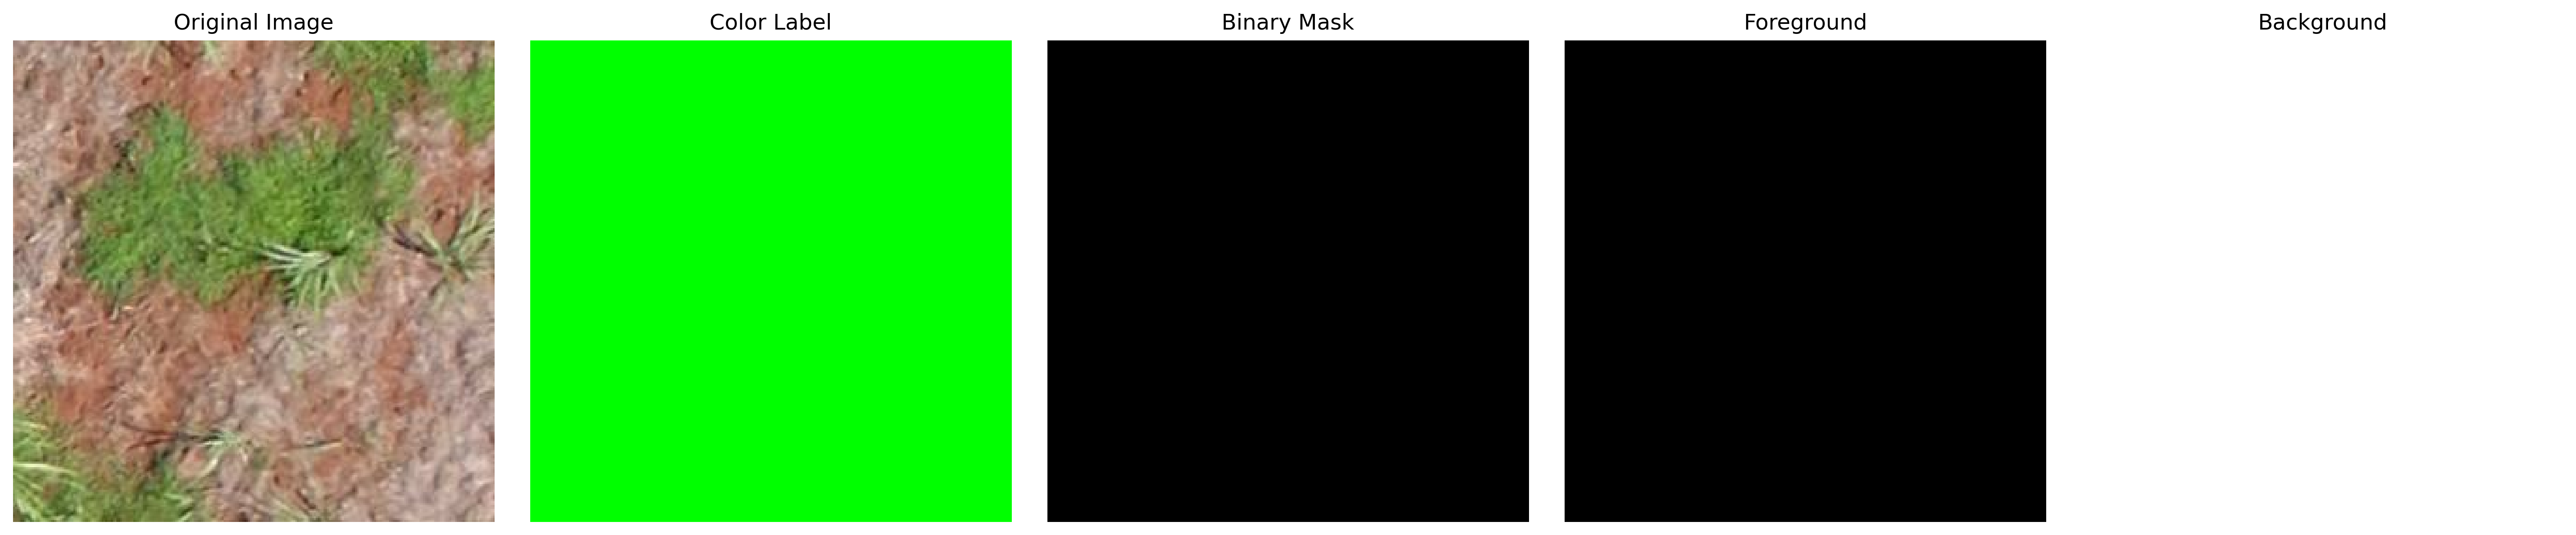

In [32]:
visualize_label_processing(labels[25], index=25)

In [103]:
PATCH_SIZE = 16
IMAGE_SIZE = 256

# quantization filter for the given patch size
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

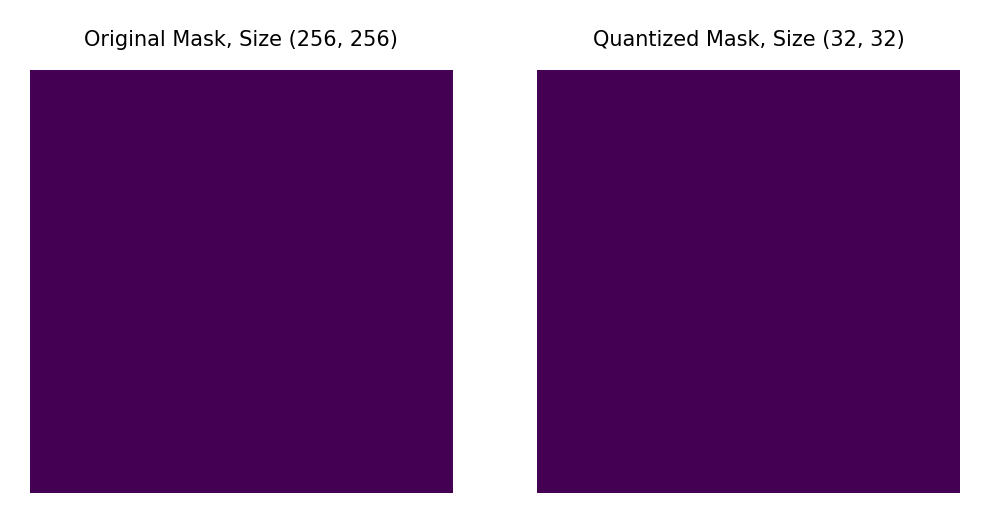

In [95]:
# Usar a função de processamento para dataset de soja
mask_0 = process_label_for_soja(images[25])
mask_0_resized = resize_transform(mask_0)
with torch.no_grad():
    mask_0_quantized = patch_quant_filter(mask_0_resized).squeeze().detach().cpu()

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(mask_0)  # Adicionar cmap='gray' para máscara binária
plt.axis('off')
plt.title(f"Original Mask, Size {mask_0.size}", fontsize=5)
plt.subplot(1, 2, 2)
plt.imshow(mask_0_quantized)  # Adicionar cmap='gray' 
plt.axis('off')
plt.title(f"Quantized Mask, Size {tuple(mask_0_quantized.shape)}", fontsize=5)
plt.show()

In [35]:
# Normalizar valores para [0,1]
mask_0_quantized = mask_0_quantized / 255.0

# Processar imagem RGB
image_i = images[25].convert('RGB')
image_i_resized = resize_transform(image_i)
image_i_resized = TF.normalize(image_i_resized, mean=SATELLITE_MEAN, std=SATELLITE_STD)
image_i_resized = image_i_resized.unsqueeze(0).cuda()


In [36]:
image_i_resized.shape

torch.Size([1, 3, 256, 256])

In [37]:
# Extrair features
feats = model.get_intermediate_layers(image_i_resized, n=range(24), reshape=True, norm=True)
feats[-1].shape


torch.Size([1, 1024, 16, 16])

In [38]:
dim = feats[-1].shape[1]
dim

1024

In [96]:
def extract_features_and_labels_soja(images, labels, model, n_layers):
    """Extrai features e labels processadas para o dataset de soja"""
    xs = []
    ys = []
    image_index = []
    
    # Usar normalização para imagens de satélite (melhor para agricultura)
    SATELLITE_MEAN = (0.430, 0.411, 0.296)
    SATELLITE_STD = (0.213, 0.156, 0.143)
    
    with torch.inference_mode():
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            for i in tqdm(range(len(images)), desc="Processing soja images"):
                # Processar label RGB para máscara binária
                label_processed = process_label_for_soja(labels[i])                               
                mask_i_resized = resize_transform(label_processed)
                mask_i_quantized = patch_quant_filter(mask_i_resized).squeeze().detach().cpu()
                mask_i_quantized = mask_i_quantized.view(-1)
                
                # Normalizar valores para [0,1]
                mask_i_quantized = mask_i_quantized / 255.0
                ys.append(mask_i_quantized)
                
                # Processar imagem RGB
                image_i = images[i].convert('RGB')
                image_i_resized = resize_transform(image_i)
                image_i_resized = TF.normalize(image_i_resized, mean=SATELLITE_MEAN, std=SATELLITE_STD)
                image_i_resized = image_i_resized.unsqueeze(0).cuda()

                # Extrair features
                feats = model.get_intermediate_layers(image_i_resized, n=range(n_layers), reshape=True, norm=True)
                dim = feats[-1].shape[1]
                xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())

                image_index.append(i * torch.ones(ys[-1].shape))

    return xs, ys, image_index


In [108]:
MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

# Usar a nova função de extração
xs, ys, image_index = extract_features_and_labels_soja(images, labels, model, n_layers)

Processing soja images: 100%|██████████| 764/764 [00:22<00:00, 33.60it/s]


In [109]:
xs = torch.cat(xs)
ys = torch.cat(ys)
image_index = torch.cat(image_index)


In [113]:
# Aplicar o PCA
from sklearn.decomposition import PCA

# Reduzir a dimensionalidade das features extraídas
pca = PCA(n_components=3)
#xs_pca = pca.fit_transform(xs.reshape(xs.shape[0], -1))
xs_pca = pca.fit_transform(xs.numpy())
#xs_pca = torch.tensor(xs_pca, dtype=torch.float32)
#xs_pca.shape, ys.shape

fg_score_pca = xs_pca[:, 0].reshape(h_patches, w_patches)  # Usar a primeira componente principal como score de foreground

fg_score_pca

ValueError: cannot reshape array of size 195584 into shape (16,16)

In [ ]:

fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

rgb_label = load_image(test_label_fpath)
mask_label = process_label_for_soja(rgb_label)

foreground_label = Image.composite(test_image, Image.new('RGB', test_image.size, (0, 0, 0)), mask_label)

plt.figure(figsize=(9, 4), dpi=300)
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(test_image_resized.permute(1, 2, 0))
plt.title('input image')
plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(foreground_label)
plt.title('input label')
plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(fg_score)
plt.title('foreground score')
plt.subplot(1, 4, 4)
plt.axis('off')
plt.imshow(fg_score_mf)
plt.title('+ median filter')
plt.show()

Image patches size: 16 x 16


ValueError: cannot reshape array of size 195584 into shape (16,16)

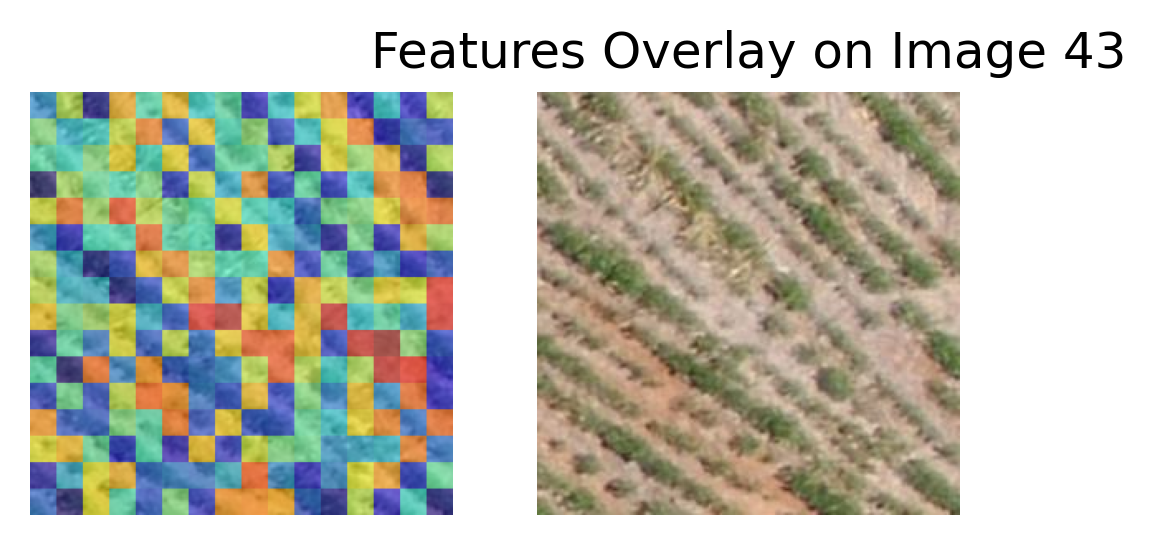

In [107]:
# Plotar em uma imagem
def plot_features_on_image(xs, ys, image_index, image_id, original_image, patch_size=16):
    """Plota as features extraídas sobre a imagem original"""
    mask_size = int(np.sqrt(xs.shape[0]))
    feature_map = xs[:, 0].reshape(mask_size, mask_size).numpy()  # Usar a primeira componente PCA para visualização
    feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())  # Normalizar para [0,1]
    feature_map_resized = np.array(Image.fromarray((feature_map * 255).astype(np.uint8)).resize(original_image.size, Image.NEAREST))
    
    plt.figure(figsize=(4, 2), dpi=300)
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.imshow(feature_map_resized, cmap='jet', alpha=0.5)  # Overlay com transparência
    plt.axis('off')
    # Imagem original ao lado
    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"Features Overlay on Image {image_id}", fontsize=12)
    plt.show()
    
image_id = 43
image_mask = (image_index == image_id)
plot_features_on_image(xs_pca[image_mask], ys[image_mask], image_index[image_mask], image_id, images[image_id])

In [48]:
# Filtrar patches com labels claros
idx = (ys < 0.01) | (ys > 0.99)
xs = xs[idx]
ys = ys[idx]
image_index = image_index[idx]

print("Design matrix of size:", xs.shape)
print("Label matrix of size:", ys.shape)



Design matrix of size: torch.Size([195584, 1024])
Label matrix of size: torch.Size([195584])


In [58]:
ys[1]

tensor(0.)

# Abordagem 2: considerar tudo ou quase tudo como foreground

In [49]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Usar k-fold ao invés de leave-one-out para 764 imagens
N_FOLDS = 5  # ou 10 folds
cs = np.logspace(-7, 0, 8)
scores = np.zeros((N_FOLDS, len(cs)))

# Criar labels por imagem para stratified split
image_labels = []
for i in range(n_images):
    img_mask = image_index == float(i)
    # Calcular proporção de foreground por imagem
    foreground_ratio = (ys[img_mask] > 0).float().mean()
    image_labels.append(int(foreground_ratio > 0.1))  # Threshold para binarizar

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

for fold_idx, (train_images, val_images) in enumerate(skf.split(range(n_images), image_labels)):
    print(f'Validation fold {fold_idx + 1}/{N_FOLDS}')
    
    # Criar seleção baseada nas imagens do fold
    train_selection = torch.isin(image_index, torch.tensor(train_images, dtype=torch.float))
    val_selection = torch.isin(image_index, torch.tensor(val_images, dtype=torch.float))
    
    fold_x_train = xs[train_selection].numpy()
    fold_y_train = (ys[train_selection] > 0).long().numpy()
    fold_x_val = xs[val_selection].numpy()
    fold_y_val = (ys[val_selection] > 0).long().numpy()

    plt.figure(figsize=(12, 8))
    for j, c in enumerate(cs):
        print(f"Training logistic regression with C={c:.2e}")
        clf = LogisticRegression(random_state=0, C=c, max_iter=10000).fit(fold_x_train, fold_y_train)
        output = clf.predict_proba(fold_x_val)
        precision, recall, thresholds = precision_recall_curve(fold_y_val, output[:, 1])
        s = average_precision_score(fold_y_val, output[:, 1])
        scores[fold_idx, j] = s
        plt.plot(recall, precision, label=f'C={c:.1e} AP={s*100:.1f}')

    plt.grid()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Fold {fold_idx + 1} - Precision-Recall Curves')
    plt.axis([0, 1, 0, 1])
    plt.legend()
    plt.show()

Validation fold 1/5
Training logistic regression with C=1.00e-07


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

<Figure size 1200x800 with 0 Axes>

### Choosing the Best C
Now, let's have a look at which value of C works best on average. To this end we will plot the average mAP across all validation images.

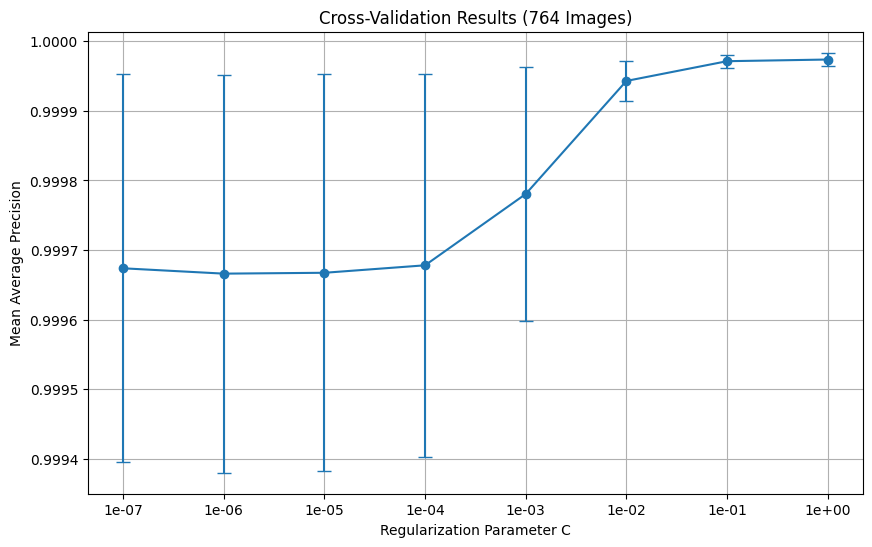

Melhor C: 1.00e+00 com mAP: 1.000 ± 0.000


In [193]:
# Plotar apenas média dos folds ao invés de todos os gráficos individuais
plt.figure(figsize=(10, 6))
mean_scores = scores.mean(axis=0)
std_scores = scores.std(axis=0)

plt.errorbar(range(len(cs)), mean_scores, yerr=std_scores, marker='o', capsize=5)
plt.xticks(range(len(cs)), [f"{c:.0e}" for c in cs])
plt.xlabel('Regularization Parameter C')
plt.ylabel('Mean Average Precision')
plt.title('Cross-Validation Results (764 Images)')
plt.grid(True)
plt.show()

# Encontrar melhor C
best_c_idx = np.argmax(mean_scores)
best_c = cs[best_c_idx]
print(f"Melhor C: {best_c:.2e} com mAP: {mean_scores[best_c_idx]:.3f} ± {std_scores[best_c_idx]:.3f}")

In [194]:
# Treinar modelo final com melhor C
print(f"Treinando modelo final com C={best_c:.2e}")
clf_final = LogisticRegression(
    random_state=0, 
    C=best_c, 
    max_iter=100000, 
    verbose=1,
    n_jobs=-1  # Usar todos os cores disponíveis
)

clf_final.fit(xs.numpy(), (ys > 0).long().numpy())

Treinando modelo final com C=1.00e+00


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,100000
,multi_class,'deprecated'


### Test Images and Inference 

We have a classifier, now it is time to test it! We will predict the probability of patch being foreground given an image, and then process it with a 3x3 median filter to smooth it out.

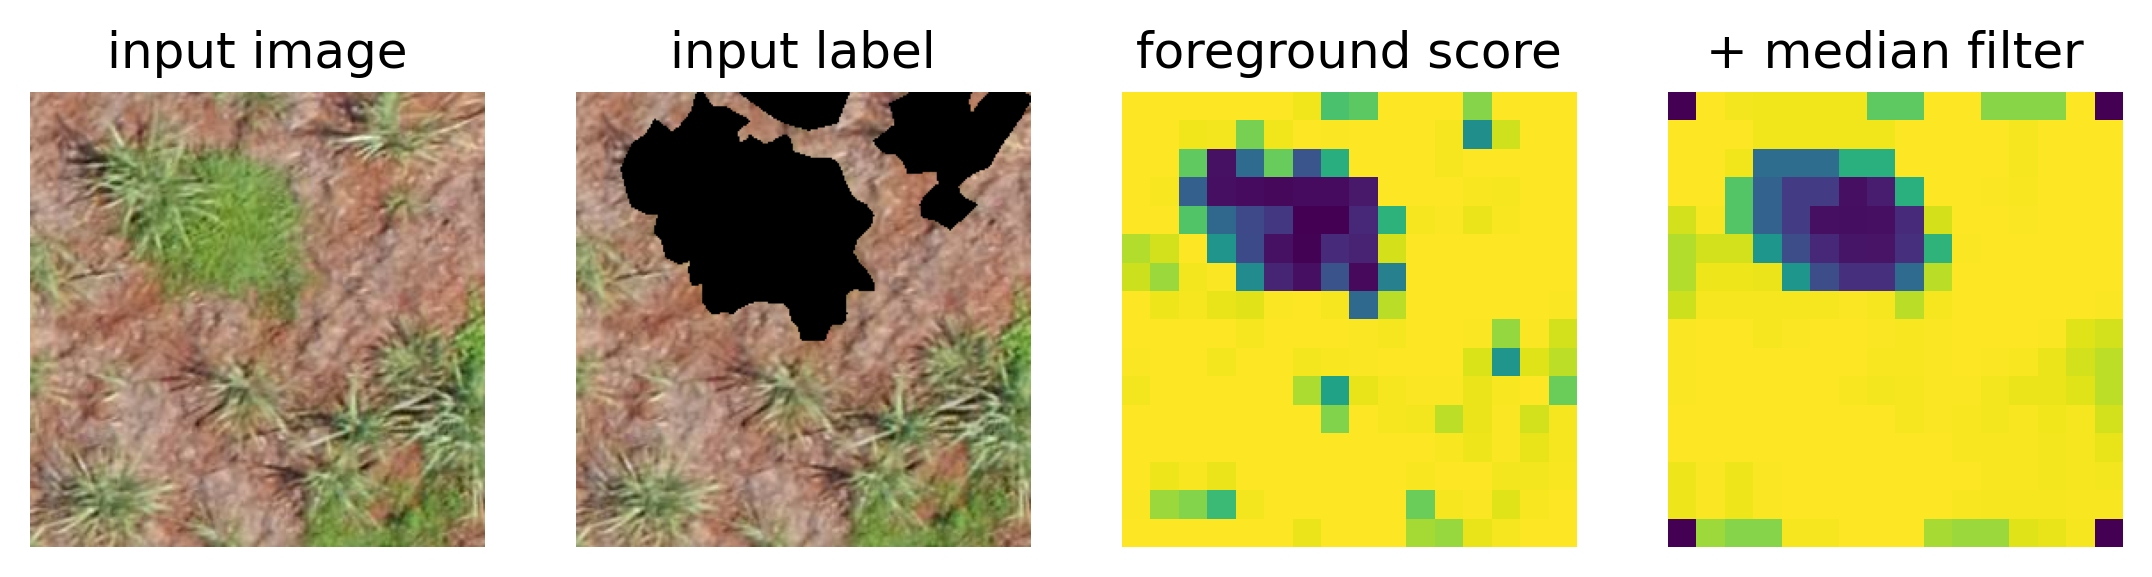

In [200]:
test_image_name = "2025-06-13_198 - Figueira (Scatolin) 04 Soja - 08 01 25 Survey_11355_17111.jpg"
test_image_name = "2025-06-13_198 - Figueira (Scatolin) 04 Soja - 08 01 25 Survey_10994_18310.jpg"
test_image_name = "2025-06-13_198 - Figueira (Scatolin) 04 Soja - 08 01 25 Survey_13074_22464.jpg"
test_image_fpath = f"/home/lades/computer_vision/wesley/dataset/daninhas_multiclasse2/rgb/val/{test_image_name}"
test_label_fpath = f"/home/lades/computer_vision/wesley/dataset/daninhas_multiclasse2/labels/val/{test_image_name}"

# Apenas uma validação, pois em alguns casos a extensão é .png ou vice-versa
if not os.path.exists(test_label_fpath):
    test_label_fpath = test_label_fpath.replace('.jpg', '.png')
    
    if not os.path.exists(test_label_fpath):
        raise FileNotFoundError(f"Label file not found for {test_image_name}")

def load_image(path: str) -> Image:
    return Image.open(path).convert("RGB")


test_image = load_image(test_image_fpath)
test_image_resized = resize_transform(test_image)
test_image_normalized = TF.normalize(test_image_resized, mean=SATELLITE_MEAN, std=SATELLITE_STD)

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        feats = model.get_intermediate_layers(test_image_normalized.unsqueeze(0).cuda(), n=range(n_layers), reshape=True, norm=True)
        x = feats[-1].squeeze().detach().cpu()
        dim = x.shape[0]
        x = x.view(dim, -1).permute(1, 0)

h_patches, w_patches = [int(d / PATCH_SIZE) for d in test_image_resized.shape[1:]]

fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

rgb_label = load_image(test_label_fpath)
mask_label = process_label_for_soja(rgb_label)

foreground_label = Image.composite(test_image, Image.new('RGB', test_image.size, (0, 0, 0)), mask_label)

plt.figure(figsize=(9, 4), dpi=300)
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(test_image_resized.permute(1, 2, 0))
plt.title('input image')
plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(foreground_label)
plt.title('input label')
plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(fg_score)
plt.title('foreground score')
plt.subplot(1, 4, 4)
plt.axis('off')
plt.imshow(fg_score_mf)
plt.title('+ median filter')
plt.show()

### Saving the Model for Future Use
We are nearly done, let's just save a pickle with the classifier.


In [12]:
save_root = '.'
model_path = os.path.join(save_root, "fg_classifier.pkl")
with open(model_path, "wb") as f:
  pickle.dump(clf, f)